# Capital Allocation Problem
## Author: Snigdhayan Mahanta

In a large corporation the `capital allocation problem` is one of the biggest challenges for the corporate decision-makers. A `corporation` consists of several `business units`. From a high level perspective a corporation can choose to deploy its financial resources in the following different ways:
1. organic growth
2. portfolio diversification (including M&A)
3. debt reduction
4. shareholder dividends
5. share buyback

In this notebook I will focus solely on the organic growth option. A `business cycle` is a strategy execution period based on a fixed capital allocation. There are two extreme ways to allocate capital for organic growth:
1. `Inertial Corporation` - at the beginning of each business cycle the business units allocate their own capital according to the growth forecasts (each business unit allocates a fraction of its own capital into organic growth; higher growth forecast would imply higher probability of capital allocation toward organic growth)
2. `Dynamic Corporation` - at the beginning of each business cycle the corporation reallocates capital between the business units solely based on the growth forecasts of the business units (the corporation can reallocate capital from one business unit into another according to the growth forecasts of the individual business units).

I created an instance of an `Inertial Corporation` and an instance of a `Dynamic Corporation`. They both have identical organizational and financial structures but there is a slight variation in their business operations. The market periodically (at the beginning of each business cycle) updates the growth forecasts for their business units identically. Based on these assumptions I simulated and evaluated their financial performances across several business cycles mainly by tracking two financial metrics - `profits` and `profit margin`.

The metric `capital held` that I estimated below can be taken as an indicator for the capital that the corporation has decided to allocate for other purposes like inorganic growth. My analysis disregards the opportunity cost of inorganic growth at this point. For a more comprehensive analysis from the growth perspective one must also take the inorganic growth option into account.

In [1]:
from typing import Sequence
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class definition of 'Business Unit'
class BusinessUnit:
    '''
    a business unit has its own P&L responsibility
    
    '''
    
    def __init__(self, label: str, forecast: int, capital: float, revenues: float, expenses: float) -> None:
        self.label = label
        self.forecast = forecast 
        self.capital = capital
        self.revenues = revenues
        self.expenses = expenses
       
    @property
    def profits(self) -> float: 
        return self.revenues - self.expenses
        
    def update_forecast(self, forecast: int) -> None:
        self.forecast = forecast

In [3]:
# Class definition of 'Corporation'
class Corporation:
    '''
    a corporation consists of multiple business units with aggregated P&L
    
    '''
    
    def __init__(self, label: str, BusinessUnits: Sequence[BusinessUnit]) -> None:
        self.label = label
        self.BusinessUnits = BusinessUnits
        
    @property
    def capital(self) -> float: 
        return sum([BusinessUnit.capital for BusinessUnit in self.BusinessUnits])
        
    @property
    def revenues(self) -> float: 
        return sum([BusinessUnit.revenues for BusinessUnit in self.BusinessUnits])
    
    @property
    def expenses(self) -> float: 
        return sum([BusinessUnit.expenses for BusinessUnit in self.BusinessUnits])
    
    @property
    def profits(self) -> float: 
        return sum([BusinessUnit.profits for BusinessUnit in self.BusinessUnits])
    
    @property
    def profit_margin(self) -> float: 
        return (self.profits/self.revenues)*100
    
            
    def operate(self, cycle_length:int) -> None: # one iteration of business operations
        for _ in range(cycle_length):
            for BusinessUnit in self.BusinessUnits:
                operational_change = np.random.choice([0, 1], p=[0.2, 0.8])
                if (operational_change == 1): 
                    delta1 = np.random.choice([0, 0.0005, 0.001, 0.0015, 0.002])
                    delta2 = np.random.choice([-0.01, -0.005, 0, 0.005, 0.01])
                    if (BusinessUnit.revenues + delta1*BusinessUnit.forecast*BusinessUnit.capital > 0):
                        BusinessUnit.revenues += delta1*BusinessUnit.forecast*BusinessUnit.capital
                    if (BusinessUnit.expenses + delta2*BusinessUnit.expenses > 0):
                        BusinessUnit.expenses += delta2*BusinessUnit.expenses

In [4]:
class Inertial_Corporation(Corporation):
    '''
    incremental capital allocation within business unit ensuring business continuity
    
    '''
    
    def allocate_capital(self) -> float: 
        redeployed_capital = 0
        for BusinessUnit in self.BusinessUnits: 
            if (BusinessUnit.profits > 0):
                if (BusinessUnit.forecast == -1): fraction = np.random.choice(range(10, 30))/100
                if (BusinessUnit.forecast == 0): fraction = np.random.choice(range(30, 50))/100
                if (BusinessUnit.forecast == 1): fraction = np.random.choice(range(50, 70))/100
                added_capital = fraction*BusinessUnit.profits
                BusinessUnit.capital += added_capital
                redeployed_capital += added_capital
        return redeployed_capital

In [5]:
class Dynamic_Corporation(Corporation):
    '''
    cross business unit capital reallocation according to growth forecasts
    
    '''

    def allocate_capital(self) -> float: 
        BU_forecasts = [BusinessUnit.forecast for BusinessUnit in self.BusinessUnits]
        redeployable_capital = self.profits
        redeployed_capital = 0
        allocation = []
        for BusinessUnit in self.BusinessUnits:
            if (BusinessUnit.forecast == -1): 
                reallocation = (np.random.choice(range(10, 20))/100)*BusinessUnit.capital
                redeployable_capital += reallocation
                BusinessUnit.capital -= reallocation
        if (redeployable_capital > 0):
            for BusinessUnit in self.BusinessUnits:
                if (BusinessUnit.forecast == -1): 
                    allocation.append(np.random.choice(range(10, 30))/100)
                if (BusinessUnit.forecast == 0): 
                    allocation.append(np.random.choice(range(30, 50))/100)
                if (BusinessUnit.forecast == 1): 
                    allocation.append(np.random.choice(range(50, 70))/100)
            allocation = (np.random.choice(range(10, 80))/100)*(allocation/sum(allocation))
            redeployed_capital = sum(allocation)*redeployable_capital
            i = 0
            for BusinessUnit in self.BusinessUnits:
                BusinessUnit.capital += allocation[i]*redeployable_capital
                i += 1
        return redeployed_capital

In [6]:
# The market updates the growth forecasts of the business units (external factor)
def update_market_forecasts(Corporations: Sequence[Corporation]) -> None:
    BU_pairs = zip(Corporations[0].BusinessUnits, Corporations[1].BusinessUnits)
    for BU_pair in BU_pairs:
        change_forecast = np.random.choice([0, 1], p=[0.8, 0.2])
        if (change_forecast == 1):
            new_forecast = np.random.choice(Forecast_options)
            BU_pair[0].update_forecast(new_forecast)
            BU_pair[1].update_forecast(new_forecast)

In [7]:
# Utility function to create a list of business units
def create_BU_list(n_BusinessUnits: int) -> Sequence[BusinessUnit]:
    BusinessUnits = []
    for i in range(1, n_BusinessUnits+1):
        label = "BU_"+str(i) # label is a simple enuramation of the business units
        forecast = np.random.choice(Forecast_options, p=[0.3, 0.4, 0.3]) 
        capital = np.random.choice(a=range(50000, 100000))
        revenues = np.random.choice(a=range(15000, 20000))
        expenses = np.random.choice(a=range(15000, 20000))
        BusinessUnits.append(BusinessUnit(label, forecast, capital, revenues, expenses))
    return BusinessUnits

In [8]:
# Utility function to create a pair of corporations with identical structures
def create_corp_pair(n_BusinessUnits: int) -> Sequence[Corporation]:
    BU_list1 = create_BU_list(n_BusinessUnits)
    Corporation1 = Inertial_Corporation("Inertial Corporation", BU_list1)
    BU_list2 = copy.deepcopy(BU_list1)
    Corporation2 = Dynamic_Corporation("Dynamic Corporation", BU_list2)
    return [Corporation1, Corporation2]

In [9]:
# Create a pair of corporations
n_BusinessUnits = 6 # no. of business units in the corporations
Forecast_options = [-1, 0, 1] # -1 = Dispose, 0 = Maintain, 1 = Grow

Corporation1, Corporation2 = create_corp_pair(n_BusinessUnits)

# The initial financial metrics
BU_forecasts1 = [BusinessUnit.forecast for BusinessUnit in Corporation1.BusinessUnits]
BU_capitals1 = [BusinessUnit.capital for BusinessUnit in Corporation1.BusinessUnits]
BU_revenues1 = [BusinessUnit.revenues for BusinessUnit in Corporation1.BusinessUnits]
BU_expenses1 = [BusinessUnit.expenses for BusinessUnit in Corporation1.BusinessUnits]
BU_profits1 = [BusinessUnit.profits for BusinessUnit in Corporation1.BusinessUnits]
corporation_profits1 = Corporation1.profits
corporation_profit_margin1 = Corporation1.profit_margin

BU_forecasts2 = [BusinessUnit.forecast for BusinessUnit in Corporation2.BusinessUnits]
BU_capitals2 = [BusinessUnit.capital for BusinessUnit in Corporation2.BusinessUnits]
BU_revenues2 = [BusinessUnit.revenues for BusinessUnit in Corporation2.BusinessUnits]
BU_expenses2 = [BusinessUnit.expenses for BusinessUnit in Corporation2.BusinessUnits]
BU_profits2 = [BusinessUnit.profits for BusinessUnit in Corporation2.BusinessUnits]
corporation_profits2 = Corporation2.profits
corporation_profit_margin2 = Corporation2.profit_margin

In [10]:
# Simulate business cycles
n_cycles = 10 # no. of business cycles
cycle_length = 5 # no. of years in a business cycle
corporation1_capital = []
corporation1_redeployed_capital = []
corporation1_profits = []
corporation1_profit_margin = []
corporation2_capital = []
corporation2_redeployed_capital = []
corporation2_profits = []
corporation2_profit_margin = []

for _ in range(n_cycles):
    #allocate capital
    capital1 = Corporation1.allocate_capital()
    corporation1_capital.append(Corporation1.capital)
    corporation1_redeployed_capital.append(capital1)
    capital2 = Corporation2.allocate_capital()
    corporation2_capital.append(Corporation2.capital)
    corporation2_redeployed_capital.append(capital2)
    
    # operate business
    Corporation1.operate(cycle_length)
    corporation1_profits.append(Corporation1.profits)
    corporation1_profit_margin.append(Corporation1.profit_margin)
    Corporation2.operate(cycle_length)
    corporation2_profits.append(Corporation2.profits)
    corporation2_profit_margin.append(Corporation2.profit_margin)
    
    # the market adjusts the growth forecasts for the next business cycle
    update_market_forecasts([Corporation1, Corporation2])

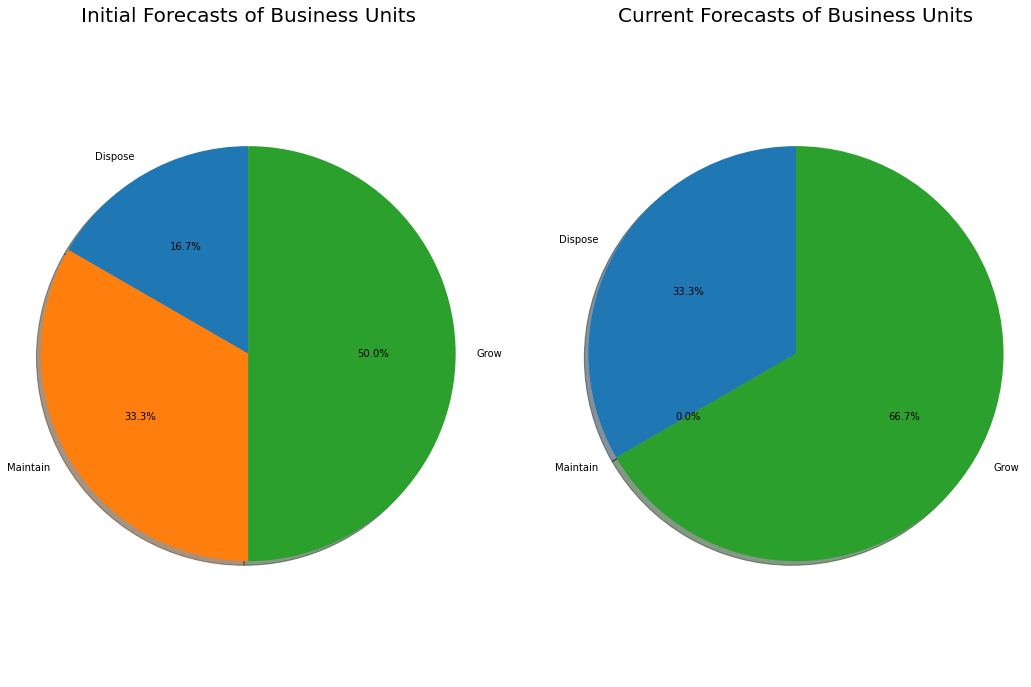

In [11]:
# Pie charts of growth forecasts of business units - initial vs. current
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Pie chart before trading period
labels = ["Dispose", "Maintain", "Grow"]
sizes1 = np.histogram(BU_forecasts1, bins=len(Forecast_options))[0]

ax1.pie(sizes1, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title(F'Initial Forecasts of Business Units', size=20)

# Pie chart after trading period
Corporation_forecasts = [BusinessUnit.forecast for BusinessUnit in Corporation1.BusinessUnits]
sizes2 = np.histogram(Corporation_forecasts, bins=len(Forecast_options))[0]

ax2.pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title(F'Current Forecasts of Business Units', size=20)

plt.show()

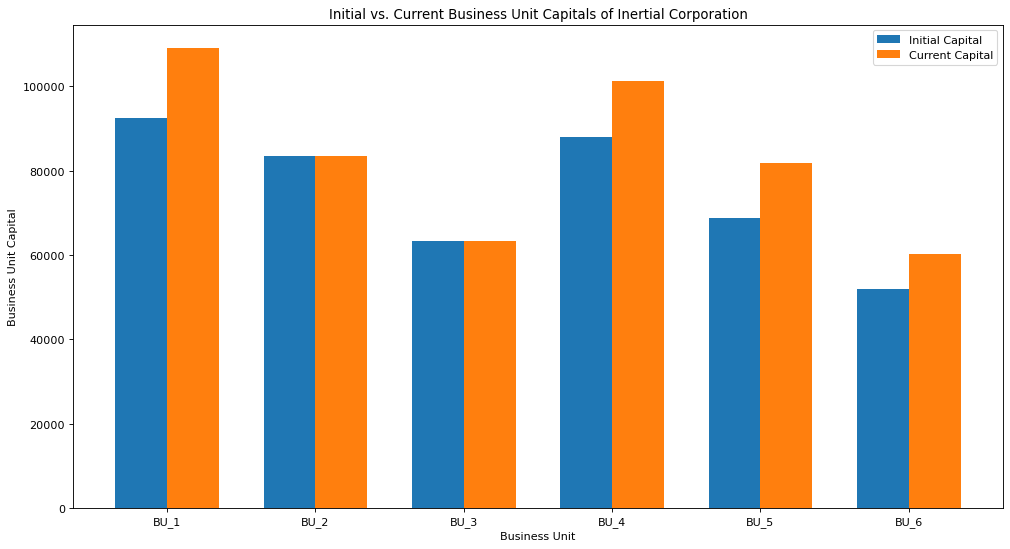

In [12]:
# Visualize the changes in business unit capitals of 'Inertial Corporation'
labels = [BusinessUnit.label for BusinessUnit in Corporation1.BusinessUnits]
x = np.arange(len(labels))  # the label locations

y1 = BU_capitals1
y2 = [BusinessUnit.capital for BusinessUnit in Corporation1.BusinessUnits]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='Initial')
rects2 = ax.bar(x + width/2, y2, width, label='Current')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Business Unit')
ax.set_ylabel(F'Business Unit Capital')
ax.set_title(F'Initial vs. Current Business Unit Capitals of {Corporation1.label}')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'Initial Capital', 
           F'Current Capital']
ax.legend(legends, loc='upper right')

plt.show()

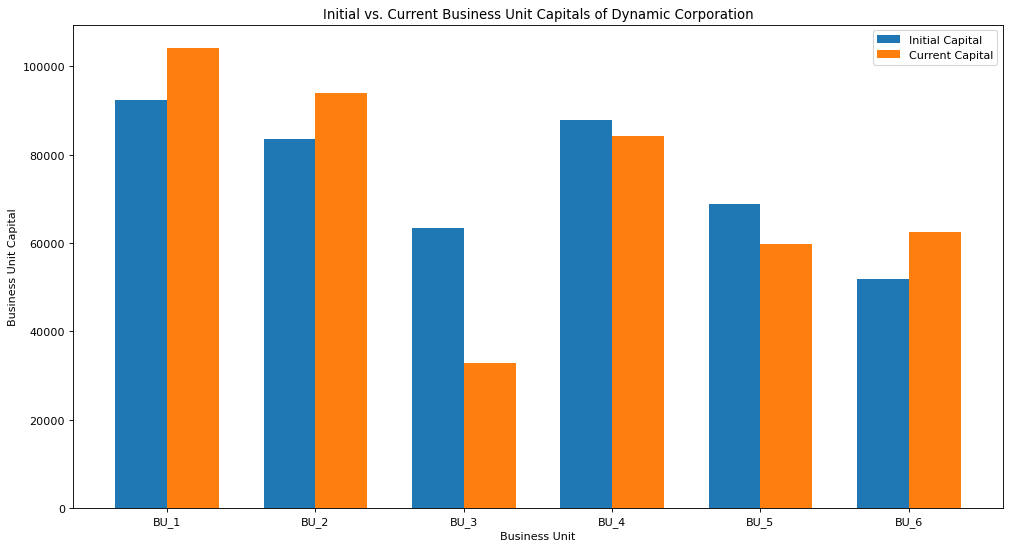

In [13]:
# Visualize the changes in business unit capitals of 'Dynamic Corporation'
labels = [BusinessUnit.label for BusinessUnit in Corporation2.BusinessUnits]
x = np.arange(len(labels))  # the label locations

y1 = BU_capitals2
y2 = [BusinessUnit.capital for BusinessUnit in Corporation2.BusinessUnits]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='Initial')
rects2 = ax.bar(x + width/2, y2, width, label='Current')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Business Unit')
ax.set_ylabel(F'Business Unit Capital')
ax.set_title(F'Initial vs. Current Business Unit Capitals of {Corporation2.label}')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'Initial Capital', 
           F'Current Capital']
ax.legend(legends, loc='upper right')

plt.show()

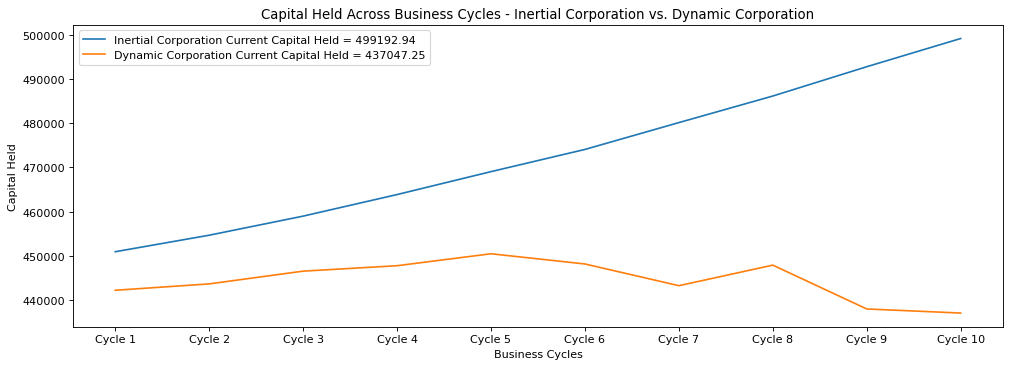

In [14]:
# Visualize the comparison of the two capital allocation strategies - capital held
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the points
# x-axis values 
x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y1 = corporation1_capital 
plt.plot(x, y1)

# x-axis values 
# x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y2 = corporation2_capital 
plt.plot(x, y2)

# x-axis label
plt.xlabel(F'Business Cycles') 

# y-axis label
plt.ylabel(F'Capital Held') 

# Title
plt.title(F'Capital Held Across Business Cycles - {Corporation1.label} vs. {Corporation2.label}')

legends = [F'{Corporation1.label} Current Capital Held = {round(Corporation1.capital, 2)}', 
           F'{Corporation2.label} Current Capital Held = {round(Corporation2.capital, 2)}']
plt.legend(legends, loc='upper left')

plt.show()

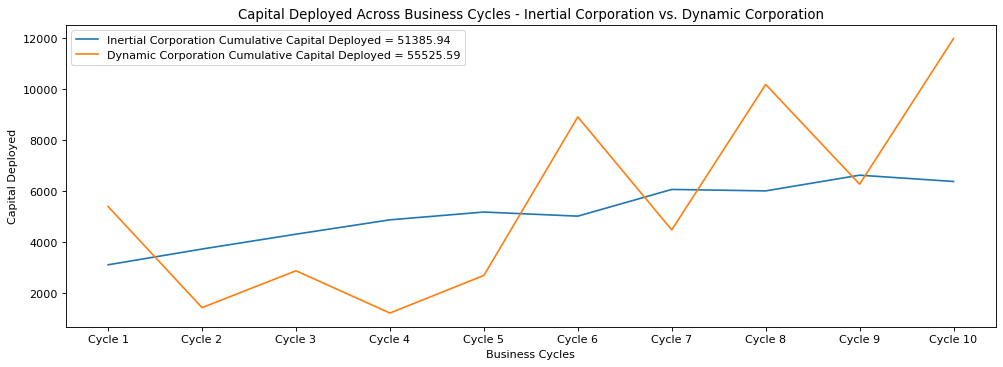

In [15]:
# Visualize the comparison of the two capital allocation strategies - capital deployed
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the points
# x-axis values 
x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y1 = corporation1_redeployed_capital 
plt.plot(x, y1)

# x-axis values 
# x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y2 = corporation2_redeployed_capital 
plt.plot(x, y2)

# x-axis label
plt.xlabel(F'Business Cycles') 

# y-axis label
plt.ylabel(F'Capital Deployed') 

# Title
plt.title(F'Capital Deployed Across Business Cycles - {Corporation1.label} vs. {Corporation2.label}')

legends = [F'{Corporation1.label} Cumulative Capital Deployed = {round(sum(y1), 2)}', 
           F'{Corporation2.label} Cumulative Capital Deployed = {round(sum(y2), 2)}']
plt.legend(legends, loc='upper left')

plt.show()

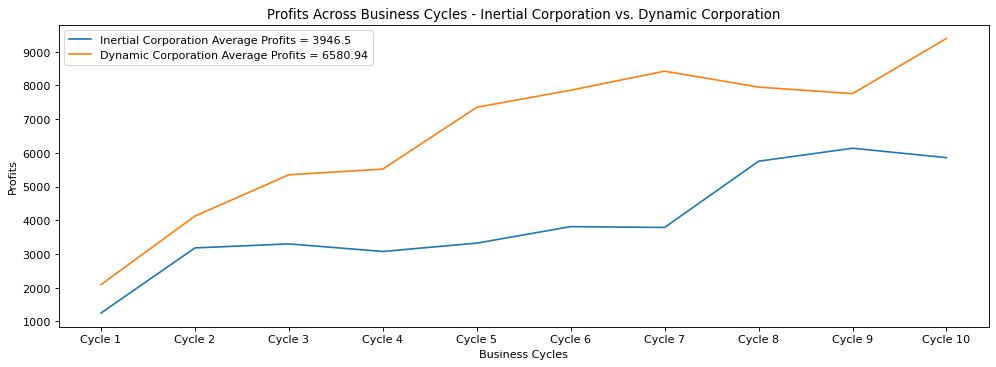

In [16]:
# Visualize the comparison of the two capital allocation strategies - profits
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the points
# x-axis values 
x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y1 = corporation1_profits 
plt.plot(x, y1)

# x-axis values 
# x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y2 = corporation2_profits
plt.plot(x, y2)

# x-axis label
plt.xlabel(F'Business Cycles') 

# y-axis label
plt.ylabel(F'Profits') 

# Title
plt.title(F'Profits Across Business Cycles - {Corporation1.label} vs. {Corporation2.label}')

legends = [F'{Corporation1.label} Average Profits = {round(sum(y1)/len(y1), 2)}', 
           F'{Corporation2.label} Average Profits = {round(sum(y2)/len(y2), 2)}']
plt.legend(legends, loc='upper left')

plt.show()

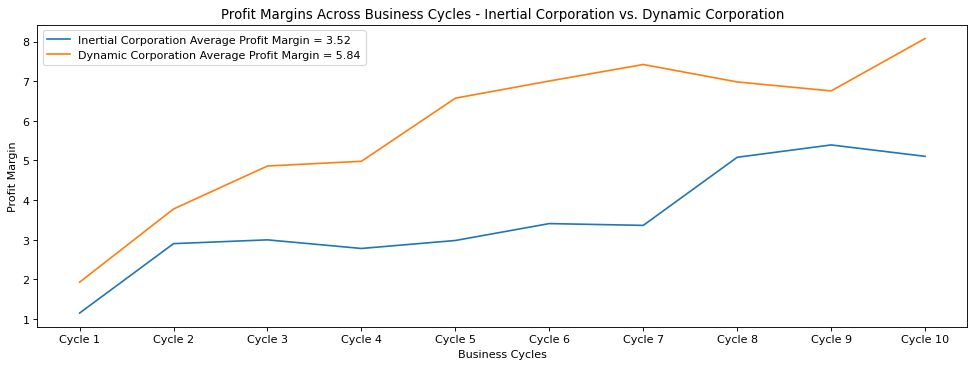

In [17]:
# Visualize the comparison of the two capital allocation strategies - profit margins
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

# Plot the points
# x-axis values 
x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y1 = corporation1_profit_margin 
plt.plot(x, y1)

# x-axis values 
# x = ["Cycle " + str(i) for i in range(1, n_cycles+1)]
# y-axis values 
y2 = corporation2_profit_margin 
plt.plot(x, y2)

# x-axis label
plt.xlabel(F'Business Cycles') 

# y-axis label
plt.ylabel(F'Profit Margin') 

# Title
plt.title(F'Profit Margins Across Business Cycles - {Corporation1.label} vs. {Corporation2.label}')

legends = [F'{Corporation1.label} Average Profit Margin = {round(sum(y1)/len(y1), 2)}', 
           F'{Corporation2.label} Average Profit Margin = {round(sum(y2)/len(y2), 2)}']
plt.legend(legends, loc='upper left')

plt.show()

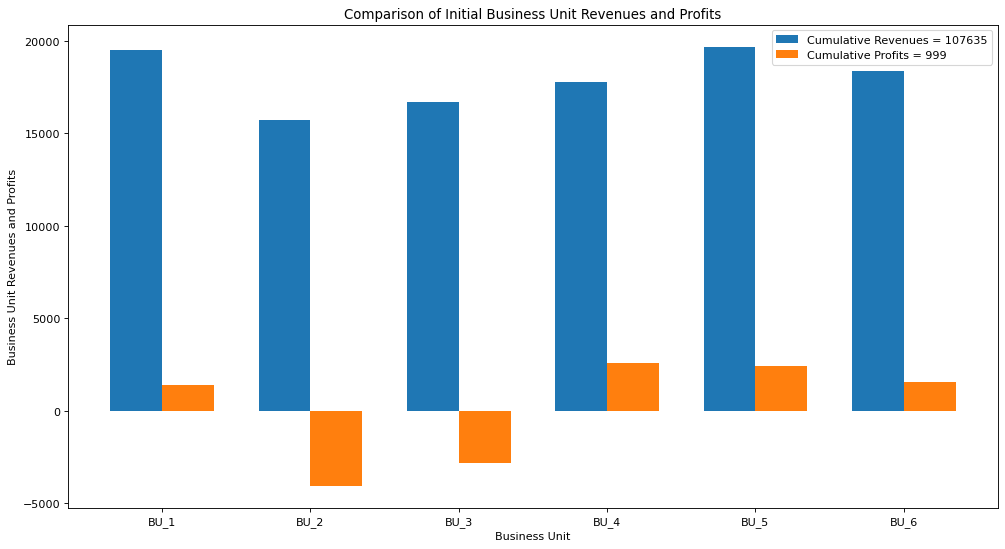

In [18]:
# Comparison of the initial business unit revenues and profits
labels = [BusinessUnit.label for BusinessUnit in Corporation1.BusinessUnits]
x = np.arange(len(labels))  # the label locations

y1 = BU_revenues1
y2 = BU_profits1

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='{Corporation1.label}')
rects2 = ax.bar(x + width/2, y2, width, label='{Corporation2.label}')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Business Unit')
ax.set_ylabel(F'Business Unit Revenues and Profits')
ax.set_title(F'Comparison of Initial Business Unit Revenues and Profits')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'Cumulative Revenues = {round(sum(y1), 2)}', 
           F'Cumulative Profits = {round(sum(y2), 2)}']
ax.legend(legends, loc='upper right')

plt.show()

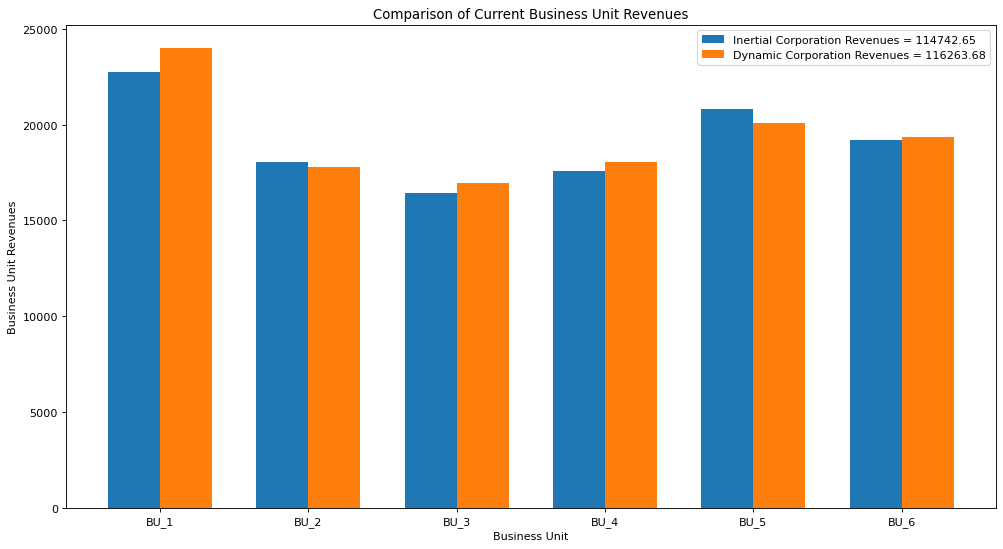

In [19]:
# Compare the current business unit revenues between the two corporations
labels = [BusinessUnit.label for BusinessUnit in Corporation1.BusinessUnits]
x = np.arange(len(labels))  # the label locations

y1 = [BusinessUnit.revenues for BusinessUnit in Corporation1.BusinessUnits]
y2 = [BusinessUnit.revenues for BusinessUnit in Corporation2.BusinessUnits]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='{Corporation1.label}')
rects2 = ax.bar(x + width/2, y2, width, label='{Corporation2.label}')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Business Unit')
ax.set_ylabel(F'Business Unit Revenues')
ax.set_title(F'Comparison of Current Business Unit Revenues')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'{Corporation1.label} Revenues = {round(Corporation1.revenues, 2)}', 
           F'{Corporation2.label} Revenues = {round(Corporation2.revenues, 2)}']
ax.legend(legends, loc='upper right')

plt.show()

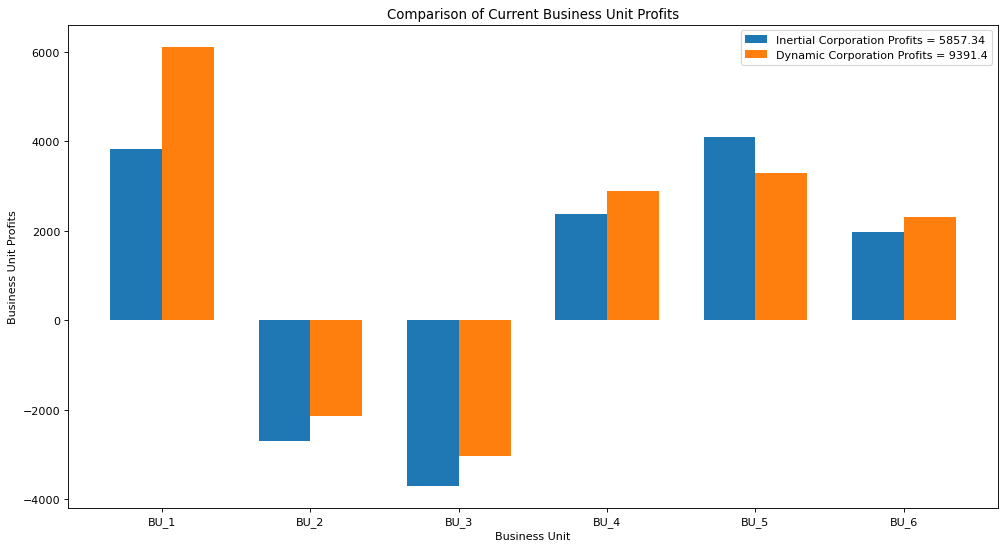

In [20]:
# Compare the current business unit profits between the two corporations
labels = [BusinessUnit.label for BusinessUnit in Corporation1.BusinessUnits]
x = np.arange(len(labels))  # the label locations

y1 = [BusinessUnit.profits for BusinessUnit in Corporation1.BusinessUnits]
y2 = [BusinessUnit.profits for BusinessUnit in Corporation2.BusinessUnits]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
rects1 = ax.bar(x - width/2, y1, width, label='{Corporation1.label}')
rects2 = ax.bar(x + width/2, y2, width, label='{Corporation2.label}')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(F'Business Unit')
ax.set_ylabel(F'Business Unit Profits')
ax.set_title(F'Comparison of Current Business Unit Profits')
ax.set_xticks(x)
ax.set_xticklabels(labels)
legends = [F'{Corporation1.label} Profits = {round(Corporation1.profits, 2)}', 
           F'{Corporation2.label} Profits = {round(Corporation2.profits, 2)}']
ax.legend(legends, loc='upper right')

plt.show()

In [21]:
# How many business cycles are under consideration?
n_cycles

10

In [22]:
# How many business units are there in the two corporations?
n_BusinessUnits

6

In [23]:
# What was the initial overall profit of the two corporations?
round(corporation_profits1, 2)

999

In [24]:
# What is the current overall profit of 'Inertial Corporation'?
round(Corporation1.profits, 2)

5857.34

In [25]:
# What is the current overall profit of 'Dynamic Corporation'?
round(Corporation2.profits, 2)

9391.4

In [26]:
# What was the initial profit margin of the two corporations?
round(corporation_profit_margin1, 2)

0.93

In [27]:
# What is the current overall profit margin of 'Inertial Corporation'?
round(Corporation1.profit_margin, 2)

5.1

In [28]:
# What is the current overall profit margin of 'Dynamic Corporation'?
round(Corporation2.profit_margin, 2)

8.08